# Sungyoung Internal Validation Study

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Users\dawson\Documents\GitHub\ode-biomarker-project


In [2]:
from PathLoader import PathLoader
path_loader = PathLoader('data_config.env', 'current_user.env')
from DataLink import DataLink
data_link = DataLink(path_loader, 'data_codes.csv')

## SY's Valiadtion Method for Curse of Dimensionality

### Setup

In [3]:
## Loading Data 

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X, y = make_regression(n_samples=1000, n_informative=50, n_features=1000, noise=0.1)
# make X,y into dataframes
X = pd.DataFrame(X)
y = pd.Series(y)

print('Loading CCLE Palbociclib..')

loading_code = 'ccle-gdsc-2-Palbociclib-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code}')

Loading CCLE Palbociclib..
Data loaded for code ccle-gdsc-2-Palbociclib-LN_IC50


In [4]:
### Functions 

def log_distributed_feature_size_list(min_size,max_size):
    # log distributed feature size list
    feature_size_list = []
    # first, find the which tenth power the min_size and max_size are
    min_power = int(np.log10(min_size))
    max_power = int(np.log10(max_size))
    # print(f'min_power: {min_power}, max_power: {max_power}')
    for power in range(min_power,max_power+1):
        for i in range(1,10):
            feature_size = i*10**power
            if feature_size <= max_size:
                feature_size_list.append(feature_size)
    return feature_size_list

def generate_feature_list(feature_data, feature_size):
    feature_list = list(feature_data.columns)
    shuffled_feature_list = np.random.permutation(feature_list)
    shuffled_feature_list = shuffled_feature_list[:feature_size]
    return shuffled_feature_list

In [5]:
### Global Parameters 

no_random_partitions = 100 
partitition_seed = 42
# set the random seed for the partitions
np.random.seed(partitition_seed)
partition_random_seed_list = list(np.random.randint(0,1000000,no_random_partitions))
features_random_seed = 0
np.random.seed(features_random_seed)
feature_sizes = log_distributed_feature_size_list(1,feature_data.shape[1])
feature_list = generate_feature_list(feature_data, feature_data.shape[1])

## File Parameters 
run_id = 'ccle_pal_2'
project_folder_name = 'SYVALID'
folder_name = "AN01_curse_of_dimensionality"
if not os.path.exists(f'{path_loader.get_data_path()}data/results/{project_folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{project_folder_name}')
    
if not os.path.exists(f'{path_loader.get_data_path()}data/results/{project_folder_name}/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{project_folder_name}/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{project_folder_name}/{folder_name}/'

In [6]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from toolkit import *

# import nearest neighbour
from sklearn.neighbors import KNeighborsRegressor

def pipeline_func(X_train, y_train, rng, feature_data, label_data, pre_selected_features, feature_size, max_iter, **kwargs):
    # NOTE: X_train, y_train are not used in this function
    model = SVR()
    # model = LinearSVR(max_iter=max_iter, random_state=rng)
    # model = KNeighborsRegressor(n_neighbors=5)
    # print(f'Feature size: {feature_size}')
    if feature_size == feature_data.shape[1]:
        selected_features = feature_data.columns
        X_selected = feature_data
    else:
        selected_features = pre_selected_features[:feature_size]
        X_selected = feature_data[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X_selected, label_data, test_size=0.2, random_state=rng)
    # print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
    model.fit(X_train, y_train)
    # print('Model fitted')
    return {'model': model,
            'selected_features': selected_features,
            'feature_size': feature_size,
            'X_test': X_test,
            'y_test': y_test
            }
    
def eval_func(X_test, y_test, pipeline_components=None, save_model=False, **kwargs):
    
    # NOTE: override the X_test, y_test with the ones from pipeline_components
    X_test = pipeline_components['X_test']
    y_test = pipeline_components['y_test']
    # print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # print(f'y_pred shape: {y_pred.shape}')
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)

    # print(f'Correlation: {corr}')
    returned_data = {'model_performance': corr, 
                     'feature_importance': None, ### DO NOT GET RID 
                     'p_vals': p_vals,
                     'selected_features': selected_features,
                     'feature_size' : pipeline_components['feature_size']
    }
    if save_model:
        returned_data['model'] = pipeline_components['model']
    return returned_data

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Performance Debugging

Performance Debugging revealed the LinearSVR is substantially faster than SVR with the linear kernal (both implemented by sklearn)

In [ ]:
model = LinearSVR(max_iter=10000)
feature_size = X.shape[1]
feature_data = X
label_data = y
print(f'Feature size: {feature_size}')
if feature_size == feature_data.shape[1]:
    selected_features = feature_data.columns
    X_selected = feature_data
    print(f'All features selected')
else:
    selected_features = feature_list[:feature_size]
    X_selected = feature_data[selected_features]
    print(f'Randomly selected features')
X_train, X_test, y_train, y_test = train_test_split(X_selected, label_data, test_size=0.2, random_state=1)
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')
model.fit(X_train, y_train)
print('Model fitted')

selected_features, X_selected = select_preset_features(X_test, y_test, selected_features)
y_pred = model.predict(X_selected)
print(f'y_pred shape: {y_pred.shape}')
# assess performance by pearson correlation
corr, p_vals = pearsonr(y_test, y_pred)

print(f'Correlation: {corr}')

### Running on Mock Data

In [ ]:
powerkit = Powerkit(X,y)

# add conditions based on feature size 

for feature_size in feature_sizes:
    powerkit.add_condition(str(feature_size), False, 
                           pipeline_func, 
                           {
                            "feature_data": X,
                            "label_data": y,
                            "pre_selected_features": feature_list, 
                            "feature_size": feature_size,
                            "max_iter": 100000
                           },
                           eval_func, 
                           {}
                           )

In [ ]:
from tqdm import tqdm

all_dfs = []
for feature_size in tqdm(feature_sizes):
    df = powerkit.run_selected_condition(str(feature_size), partition_random_seed_list, 16, False)
    all_dfs.append(df)
    
final_df = pd.concat(all_dfs)

In [ ]:
final_df.reset_index(inplace=True)

In [ ]:
# import seaborn 

import seaborn as sns
import matplotlib.pyplot as plt

# change plot size 
plt.figure(figsize=(10,6))
sns.lineplot(data=final_df, x='condition', y='model_performance')
plt.title(f'{run_id} Curse of Dimensionality and Optimal Feature Size', fontsize=18)
# xlabel and ylabel, increase font size1
plt.xlabel('Feature Size', fontsize=16)
plt.ylabel('Model Performance', fontsize=16)
# rotate x-axis labels
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()



### Mock Data Save Figure

In [ ]:
plt.savefig(f'{file_save_path}{run_id}_curse_of_dimensionality.png')

### Running on CCLE Palbociclib Data 

#### Run

In [ ]:
powerkit = Powerkit(feature_data, label_data)

# add conditions based on feature size 

for feature_size in feature_sizes:
    powerkit.add_condition(str(feature_size), False, 
                           pipeline_func, 
                           {
                            "feature_data": feature_data,
                            "label_data": label_data,
                            "pre_selected_features": feature_list, 
                            "feature_size": feature_size,
                            "max_iter": 10000
                           },
                           eval_func, 
                           {}
                           )

In [ ]:
from tqdm import tqdm

all_dfs = []
for feature_size in tqdm(feature_sizes):
    df = powerkit.run_selected_condition(str(feature_size), partition_random_seed_list, 32, False)
    all_dfs.append(df)
    
final_df = pd.concat(all_dfs)

In [ ]:
final_df.reset_index(inplace=True)

In [ ]:
# import seaborn 

import seaborn as sns
import matplotlib.pyplot as plt

# change plot size 
plt.figure(figsize=(10,6))
sns.lineplot(data=final_df, x='condition', y='model_performance')
plt.title(f'{run_id} Curse of Dimensionality and Optimal Feature Size', fontsize=18)
# xlabel and ylabel, increase font size1
plt.xlabel('Feature Size', fontsize=16)
plt.ylabel('Model Performance', fontsize=16)
# rotate x-axis labels
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()



#### Save Figure and Data

In [ ]:
plt.savefig(f'{file_save_path}{run_id}_curse_of_dimensionality.png')

In [ ]:
final_df.to_pickle(f'{file_save_path}{run_id}_curse_of_dimensionality.pkl')

In [ ]:
final_df

### Experiment 1 - Varying Random Feature List on Palbociclib CCLE Data

#### Experiment Parameters

In [ ]:
experiment_id = 'experiment_1_run_1'

In [ ]:
root_partition_seed = 15
feature_seed_size = 100
root_feature_random_seed = 42 
np.random.seed(root_feature_random_seed)
feature_random_seeds = np.random.randint(0,1000000,feature_seed_size)
all_feature_lists = []

for seed in feature_random_seeds:
    np.random.seed(seed)
    feature_list = generate_feature_list(feature_data, feature_data.shape[1])
    all_feature_lists.append(feature_list)
    
feature_sizes = log_distributed_feature_size_list(1, feature_data.shape[1])

#### Run Phase

In [ ]:
powerkit = Powerkit(feature_data, label_data)

# add conditions based on feature size 

for feature_size in feature_sizes:
    for i, feature_list in enumerate(all_feature_lists):
        powerkit.add_condition(str(feature_size)+'_'+str(feature_random_seeds[i]), 
                               False, 
                               pipeline_func, 
                               {
                                "feature_data": feature_data,
                                "label_data": label_data,
                                "pre_selected_features": feature_list, 
                                "feature_size": feature_size,
                                "max_iter": 10000
                               },
                               eval_func, 
                               {}
                               )

In [ ]:
from tqdm import tqdm
from joblib import Parallel, delayed

rng_list = [root_partition_seed]

all_dfs = []
for feature_size in tqdm(feature_sizes):
    dfs = Parallel(n_jobs=32)(delayed(powerkit.run_selected_condition)(str(feature_size)+'_'+str(seed), rng_list, 32, False) for seed in feature_random_seeds)
    large_df = pd.concat(dfs)
    all_dfs.append(large_df)
    
final_df = pd.concat(all_dfs)

#### Visualisation and Save Data

In [ ]:
final_df[['feature_size', 'feature_seed']] = final_df['condition'].str.split('_', expand=True)

In [ ]:
final_df 

In [ ]:
final_df.reset_index(inplace=True)

In [ ]:
# import seaborn 

import seaborn as sns
import matplotlib.pyplot as plt

# change plot size 
plt.figure(figsize=(10,6))
sns.lineplot(data=final_df, x='feature_size', y='model_performance')
plt.title(f'Varying Feature Lists', fontsize=18)
# xlabel and ylabel, increase font size1
plt.xlabel('Feature Size', fontsize=16)
plt.ylabel('Model Performance', fontsize=16)
# rotate x-axis labels
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()



In [ ]:
plt.savefig(f'{file_save_path}{experiment_id}_cod_plot.png')

In [ ]:
# save the dataframe as a pickle file 

final_df.to_pickle(f'{file_save_path}{experiment_id}_final_df.pkl')

experiment ids:
- experiment_1_run_1: varying feature_list randomly on palbociclib data

#### Load Data for additional analysis

In [ ]:
import pandas as pd

final_df = pd.read_pickle(f'{file_save_path}experiment_1_run_1_final_df.pkl')

In [ ]:
final_df

### Experiment 2 - Varying Signal Noise on Mock Data

Modification - the original plan was to vary signal noise while using a random feature list method. However, upon running exp3 first, I wish to prioritise the effect of signal noise on the 'select ground truth first' method.

#### Experiment Parameters

In [20]:
experiment_id = 'experiment_2_run_2'

In [21]:
no_random_partitions = 10
partitition_seed = 42
dataset_seed = 50
# set the random seed for the partitions
np.random.seed(partitition_seed)
partition_random_seed_list = list(np.random.randint(0,1000000,no_random_partitions))
max_feature_size = 1000
feature_sizes = log_distributed_feature_size_list(1,max_feature_size)
signal_noise_variation = [1000,2000,5000]

#### Run Phase

In [22]:
powerkit = Powerkit(X, y)

# add conditions based on feature size 

for feature_size in feature_sizes:
    for noise in signal_noise_variation:
        # create dataset 
        X_known, y_known = make_regression(n_samples=1000, n_informative=50, n_features=max_feature_size, noise=noise, shuffle=False, random_state=dataset_seed)
        X_known = pd.DataFrame(X_known)
        y_known = pd.Series(y_known)
        known_feature_list = list(X_known.columns)
        # add condition into powerkit
        powerkit.add_condition(str(feature_size)+'_'+str(noise), False, 
                               pipeline_func, 
                               {
                                "feature_data": X_known,
                                "label_data": y_known,
                                "pre_selected_features": known_feature_list, 
                                "feature_size": feature_size,
                                "max_iter": 10000
                               },
                               eval_func, 
                               {}
                               )

In [23]:
from tqdm import tqdm
from joblib import Parallel, delayed

rng_list = partition_random_seed_list

all_dfs = []
for feature_size in tqdm(feature_sizes):
    dfs = Parallel(n_jobs=32)(delayed(powerkit.run_selected_condition)(str(feature_size)+'_'+str(noise), rng_list, 32, False) for noise in signal_noise_variation)
    large_df = pd.concat(dfs)
    all_dfs.append(large_df)
    
final_df = pd.concat(all_dfs)

100%|██████████| 28/28 [05:46<00:00, 12.38s/it]


#### Save Data and Figure

In [24]:
final_df[['feature_size', 'noise_level']] = final_df['condition'].str.split('_', expand=True)
final_df 

,rng,condition,model_performance,p_vals,selected_features,feature_size,noise_level
0,121958,1_0,0.030030,6.729341e-01,[0],1,0
1,671155,1_0,0.118866,9.365388e-02,[0],1,0
2,131932,1_0,0.095466,1.787211e-01,[0],1,0
3,365838,1_0,0.023209,7.442663e-01,[0],1,0
4,259178,1_0,0.049045,4.904048e-01,[0],1,0
...,...,...,...,...,...,...,...
5,644167,1000_100,0.444771,4.162606e-11,"RangeIndex(start=0, stop=1000, step=1)",1000,100
6,110268,1000_100,0.482624,4.586289e-13,"RangeIndex(start=0, stop=1000, step=1)",1000,100
7,732180,1000_100,0.573654,6.769971e-19,"RangeIndex(start=0, stop=1000, step=1)",1000,100
8,54886,1000_100,0.579873,2.310882e-19,"RangeIndex(start=0, stop=1000, step=1)",1000,100


In [25]:
final_df.reset_index(inplace=True)

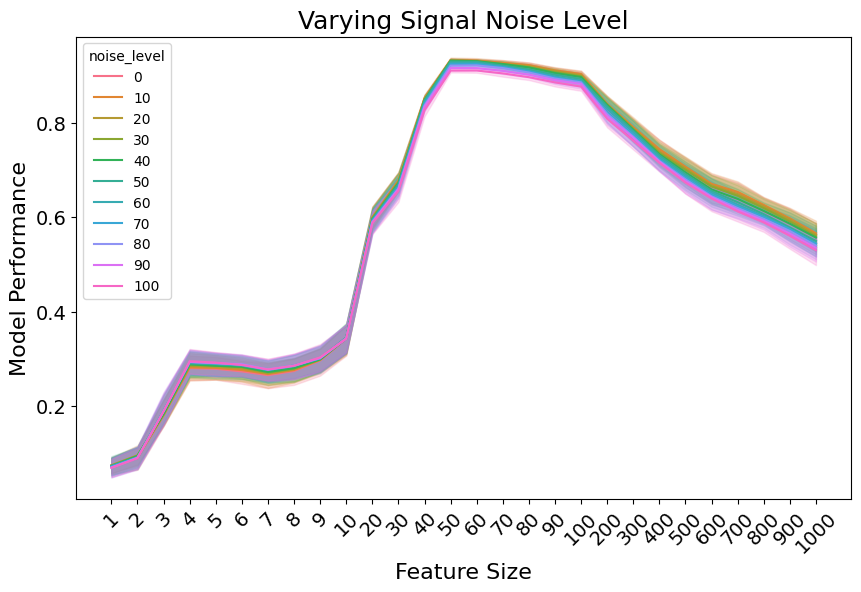

In [26]:
# import seaborn 

import seaborn as sns
import matplotlib.pyplot as plt

# change plot size 
plt.figure(figsize=(10,6))
sns.lineplot(data=final_df, x='feature_size', y='model_performance', hue='noise_level')
plt.title(f'Varying Signal Noise Level', fontsize=18)
# xlabel and ylabel, increase font size1
plt.xlabel('Feature Size', fontsize=16)
plt.ylabel('Model Performance', fontsize=16)
# rotate x-axis labels
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()



In [27]:
plt.savefig(f'{file_save_path}{experiment_id}_cod_plot.png')

<Figure size 640x480 with 0 Axes>

In [28]:
# save the dataframe as a pickle file 

final_df.to_pickle(f'{file_save_path}{experiment_id}_final_df.pkl')

#### Further Visualisations

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


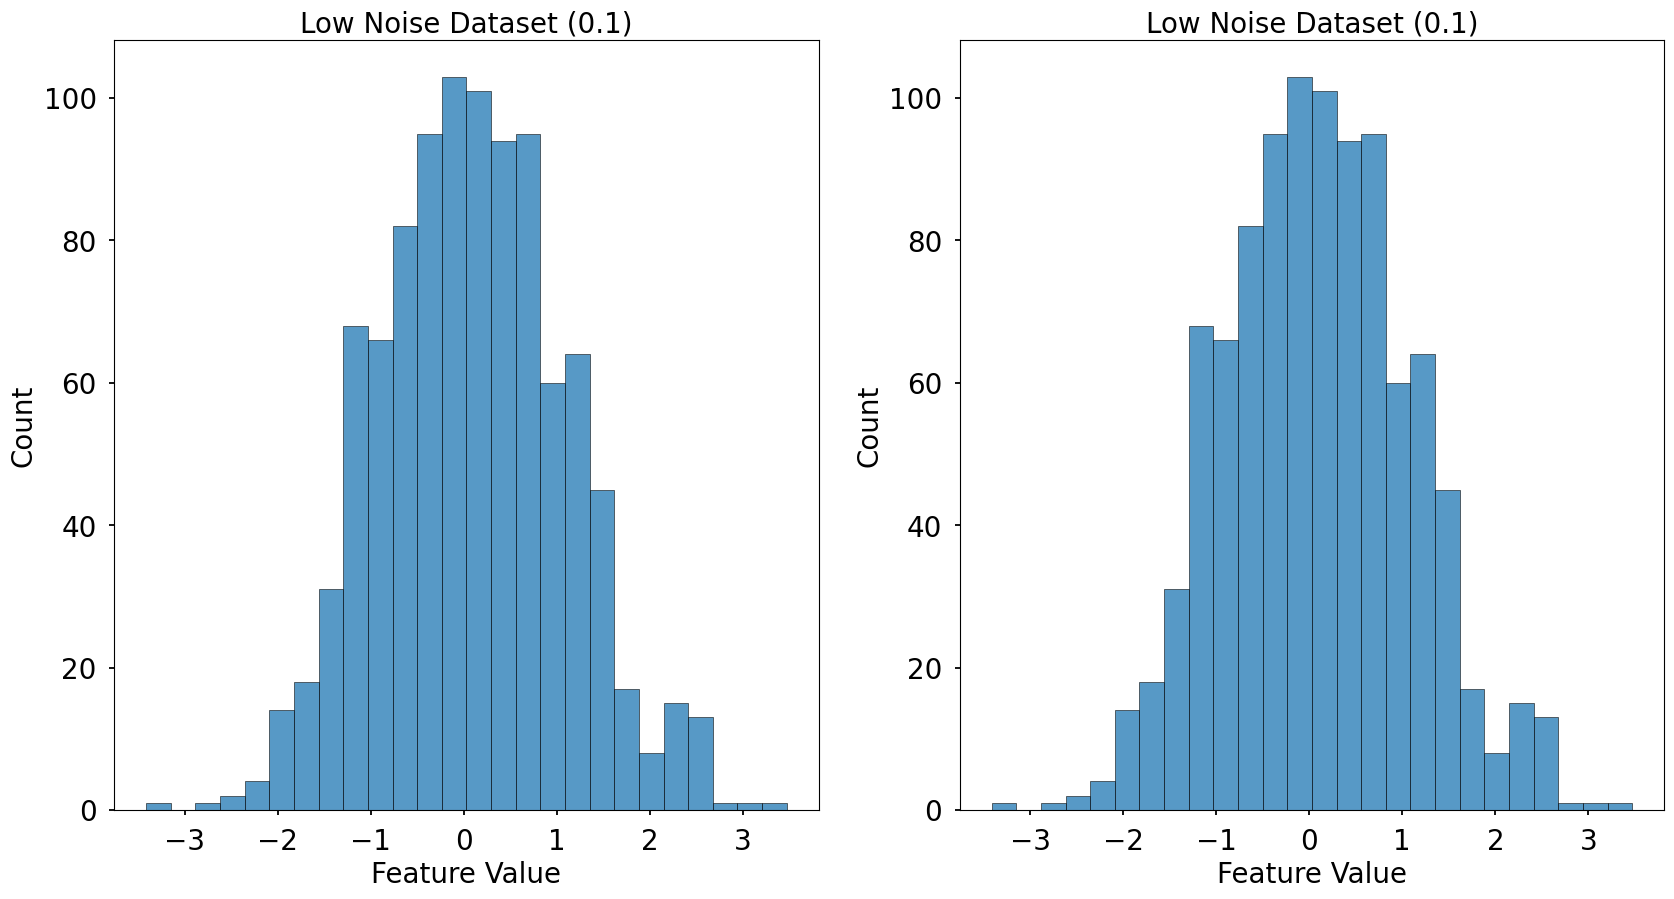

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# visualising hwo noise affects features in Make Regression datasets

X_known_low_noise, y_known_low_noise = make_regression(n_samples=1000, n_informative=50, n_features=1000, noise=0.1, shuffle=False, random_state=42)
X_known_low_noise = pd.DataFrame(X_known_low_noise)
y_known_low_noise = pd.Series(y_known_low_noise)
known_feature_list = list(X_known_low_noise.columns)

X_known_high_noise, y_known_high_noise = make_regression(n_samples=1000, n_informative=50, n_features=1000, noise=1000, shuffle=False, random_state=42)
X_known_high_noise = pd.DataFrame(X_known_high_noise)
y_known_high_noise = pd.Series(y_known_high_noise)
known_feature_list = list(X_known_high_noise.columns)

# visualise the first 10 features in the low noise dataset vs high noise dataset in two subplots
# make sns to be 'talk' size

plt.style.use('seaborn-talk')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(X_known_low_noise.iloc[:,0], ax=axs[0])
# make fonts bigger
axs[0].tick_params(axis='both', which='major', labelsize=20)
axs[0].set_xlabel('Feature Value', fontsize=20)
axs[0].set_ylabel('Count', fontsize=20)
# make title bigger
axs[0].set_title('Low Noise Dataset (0.1)', fontsize=20)
sns.histplot(X_known_high_noise.iloc[:,0], ax=axs[1])
# make fonts bigger
axs[1].tick_params(axis='both', which='major', labelsize=20)
axs[1].set_xlabel('Feature Value', fontsize=20)
axs[1].set_ylabel('Count', fontsize=20)
# make title bigger
axs[1].set_title('Low Noise Dataset (0.1)', fontsize=20)
plt.show()

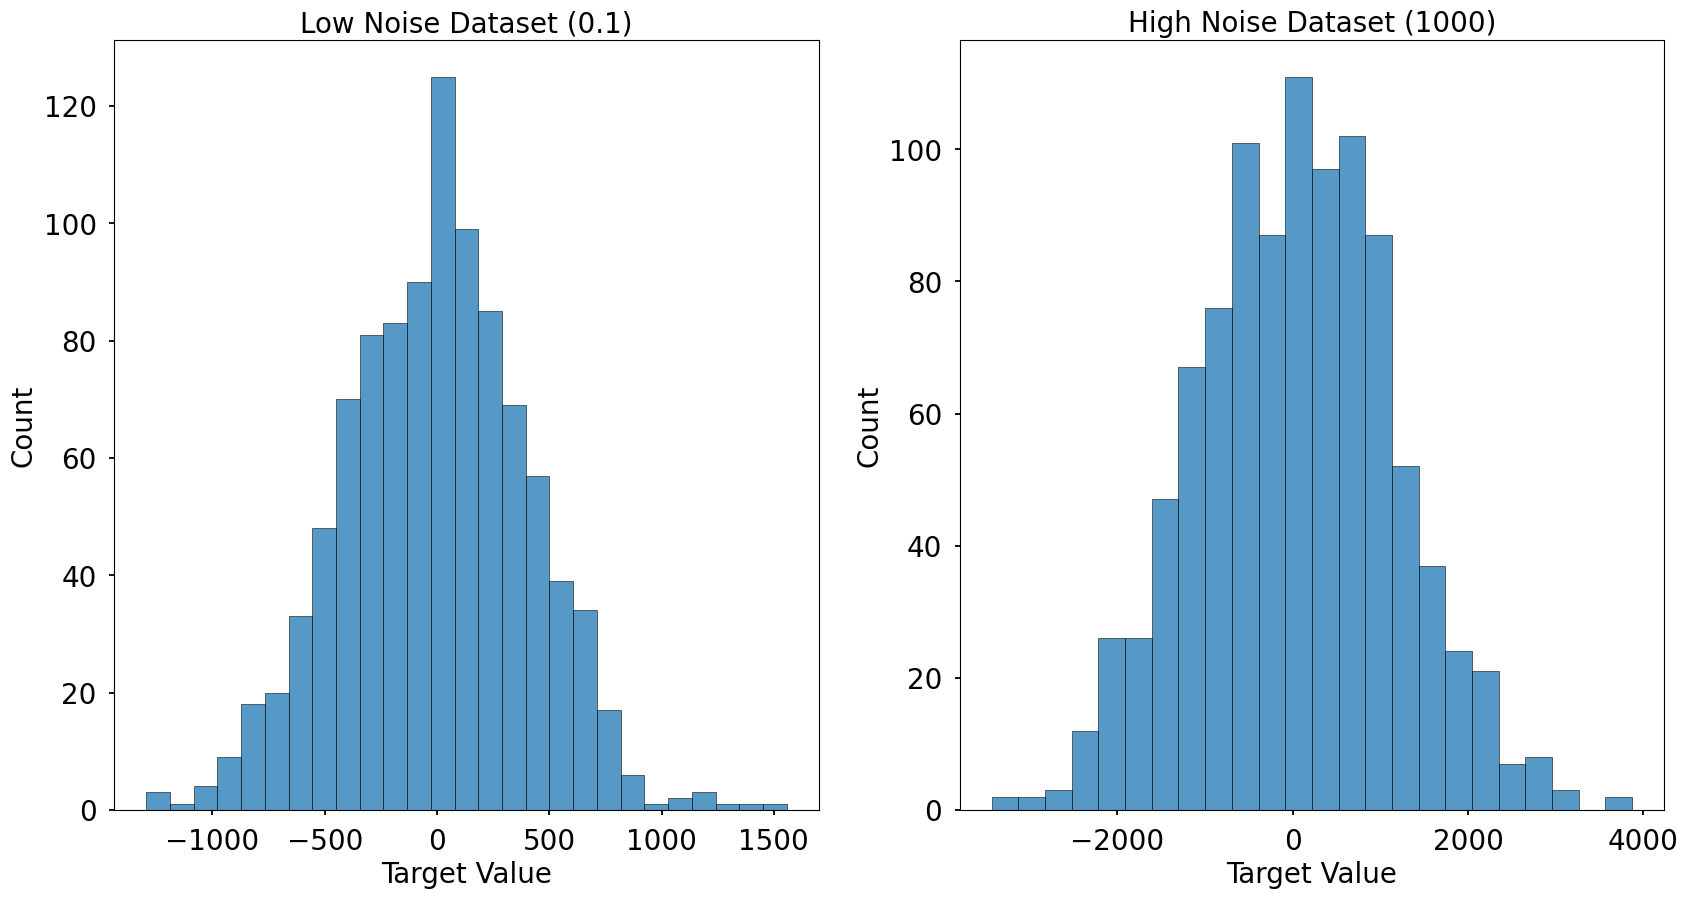

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(y_known_low_noise, ax=axs[0])
axs[0].set_title('Low Noise Dataset (0.1)', fontsize=20)
axs[0].set_xlabel('Target Value', fontsize=20)
axs[0].set_ylabel('Count', fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
sns.histplot(y_known_high_noise, ax=axs[1])
axs[1].set_title('High Noise Dataset (1000)', fontsize=20)
axs[1].set_xlabel('Target Value', fontsize=20)
axs[1].set_ylabel('Count', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
plt.show()


### Experiment 3 - Select Ground Truth First on Mock Data

This experiment aims to select ground truth features from the mock data, then gradually add useless features. 

Since the ground truth features have direct correlations with the label and useless features do not, this is expected to produce a CoD curve that peak at x features (x = no. of ground truth features) then a gradual decline. 

#### Experiment Parameters

In [ ]:
experiment_id = 'experiment_3_run_3'

In [ ]:
X_known, y_known = make_regression(n_samples=500, n_informative=20, n_features=1000, noise=0.1, shuffle=False)
# make X,y into dataframes
X_known = pd.DataFrame(X_known)
y_known = pd.Series(y_known)

known_feature_list = list(X_known.columns)

In [ ]:
no_random_partitions = 100 
partitition_seed = 15512
# set the random seed for the partitions
np.random.seed(partitition_seed)
partition_random_seed_list = list(np.random.randint(0,1000000,no_random_partitions))
feature_sizes = log_distributed_feature_size_list(1,X_known.shape[1])

#### Run Phase

In [ ]:
powerkit = Powerkit(X_known, y_known)

# add conditions based on feature size 

for feature_size in feature_sizes:
    powerkit.add_condition(str(feature_size), False, 
                           pipeline_func, 
                           {
                            "feature_data": X_known,
                            "label_data": y_known,
                            "pre_selected_features": known_feature_list, 
                            "feature_size": feature_size,
                            "max_iter": 10000
                           },
                           eval_func, 
                           {}
                           )

In [ ]:
from tqdm import tqdm

all_dfs = []
for feature_size in tqdm(feature_sizes):
    df = powerkit.run_selected_condition(str(feature_size), partition_random_seed_list, 32, False)
    all_dfs.append(df)
    
final_df = pd.concat(all_dfs)

#### Save File and Data

In [ ]:
final_df.reset_index(inplace=True)

In [ ]:
# import seaborn 

import seaborn as sns
import matplotlib.pyplot as plt

# change plot size 
plt.figure(figsize=(10,6))
sns.lineplot(data=final_df, x='condition', y='model_performance')
plt.title(f'{experiment_id} Curse of Dimensionality and Optimal Feature Size', fontsize=18)
# xlabel and ylabel, increase font size1
plt.xlabel('Feature Size', fontsize=16)
plt.ylabel('Model Performance', fontsize=16)
# rotate x-axis labels
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()



In [ ]:
plt.savefig(f'{file_save_path}{experiment_id}_cod_plot.png')
print(f'Complete - {file_save_path}{experiment_id}_cod_plot.png')
# save the dataframe as a pickle file

final_df.to_pickle(f'{file_save_path}{experiment_id}_final_df.pkl')
print(f'Complete - {file_save_path}{experiment_id}_final_df.pkl')

### Experiment 4 - Pearson Correlation on Palbociclib CCLE data as Feature Importance Score

Add 100 each time

#### Experiment Parameters

In [ ]:
experiment_id = 'experiment_4_run_1'

#### Run Phase

## SY's Rudimentary Pipeline Logic

Whole data --> Preprocessing --> Feature Selection --> Splitting --> Fitting

This is a fundamentally different process from the current Powerkit protocol. 

In [ ]:
print('Selecting the top 100 features in the data')

from toolkit import *

selected_features, scores = f_regression_select(feature_data, label_data, k=100)

In [ ]:
from sklearn.svm import SVR

model = SVR(kernel='linear')
selected_features, X_selected = select_preset_features(feature_data, label_data, selected_features)

In [ ]:
# split the data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, label_data, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
print('Model trained')

In [ ]:
# make predictions

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
# pearson correlation from scipy 
from scipy.stats import pearsonr

mse = mean_squared_error(y_test, y_pred)
pearson_corr, p_vals = pearsonr(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Pearson Correlation: {pearson_corr}, p-value: {p_vals}')




In [ ]:
### Greedy Forward Select, but without resetting the model and report the internal validation scores 

print('Greedy Forward Selecting the top 20 features in the data')

start_feature = selected_features[0]

selected_features, scores, model = greedy_feedforward_select_sy(X_selected, label_data,
                                                                k=20, 
                                                                model=model, 
                                                                start_feature=start_feature, 
                                                                cv=5,
                                                                verbose=1)

